# Wine is bottled poetry
_Note : This code contains our detailed explorative analysis. It has therefore some additional tables and graph that the pdf report_


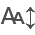

In [779]:
# Setting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import shapiro 
from scipy.stats import normaltest
from scipy.stats import anderson
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt

from dash import Dash, html, dash_table, dcc, callback, Output, Input


from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

# Note : The codes were not added in the main script but kaleido was also used to export the targeted graphs

In [780]:
# determing the path
wines = pd.read_csv("wines.txt", delimiter= ",")

## General information on the dataset

 ***2 500 ro*ws**, each row being a different bottle of wine. Our dataset include **1*2 variables*** with :
- 10 numerical variables, our explanatory variables;
- 1 qualitative variable, corresponding to the type of wine;
- and our target variable, which is a Boolean variable indicating whether a wine is considered as "great".

In [782]:
# General information to get an overview  of the dataset
wines.shape 
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         2500 non-null   float64
 1   volatile acidity      2500 non-null   float64
 2   citric acid           2500 non-null   float64
 3   residual sugar        2500 non-null   float64
 4   chlorides             2500 non-null   float64
 5   free sulfur dioxide   2500 non-null   float64
 6   total sulfur dioxide  2500 non-null   float64
 7   density               2500 non-null   float64
 8   pH                    2500 non-null   float64
 9   sulphates             2500 non-null   float64
 10  alcohol               2500 non-null   float64
 11  type                  2500 non-null   object 
 12  great wine            2500 non-null   bool   
dtypes: bool(1), float64(11), object(1)
memory usage: 236.9+ KB


No missing values were detected in the dataset.

In [784]:
#Checking for na
empty_bottle = wines.isna().sum().reset_index()
empty_bottle.columns = ["Variable", "Number of missing values"] # I use this line to add title to my columns
empty_bottle #No missing value

Variable  Number of missing values
0          fixed acidity                         0
1       volatile acidity                         0
2            citric acid                         0
3         residual sugar                         0
4              chlorides                         0
5    free sulfur dioxide                         0
6   total sulfur dioxide                         0
7                density                         0
8                     pH                         0
9              sulphates                         0
10               alcohol                         0
11                  type                         0
12            great wine                         0

## Repartion of the types of wine in the dataset
17% of the dataset (424 entries) correspond to beverages considered as "great wines".

In [786]:
# Frequency tables for great wine
a_table_for_one = pd.crosstab(wines["great wine"], "N")
a_table_for_one ["Percent"] = a_table_for_one["N"]/a_table_for_one["N"].sum()*100 
a_table_for_one ["Percent"] = a_table_for_one ["Percent"].round(0)

a_table_for_one
# Great wine = 17% of the wine in our dataset



col_0          N  Percent
great wine               
False       2076     83.0
True         424     17.0

White wines are predominant in the total of "great wines". As we can see in the table and figure below, if white wines account for 50% of the total wines in our sample, they, however, represent 61% of the bottles of "great wines".  

In [788]:
#  Two-way Frequency tables for the type of wine and its quality great wine
a_table_for_two = pd.crosstab(wines["great wine"], wines["type"], margins = True, margins_name="Total") #number of red and white wines is identical
a_table_for_two["% of Red"] = a_table_for_two["Red"]/a_table_for_two["Total"]*100
a_table_for_two["% of Red"] = a_table_for_two["% of Red"].round(1)

a_table_for_two["% of White"] = a_table_for_two["White"]/a_table_for_two["Total"]*100
a_table_for_two["% of White"] = a_table_for_two["% of White"].round(1)

a_table_for_two["Total (%)"] = a_table_for_two["% of White"] + a_table_for_two["% of Red"]
a_table_for_two

# White wines are overrepresented in the total of great wine (61%)

type         Red  White  Total  % of Red  % of White  Total (%)
great wine                                                     
False       1086    990   2076      52.3        47.7      100.0
True         164    260    424      38.7        61.3      100.0
Total       1250   1250   2500      50.0        50.0      100.0

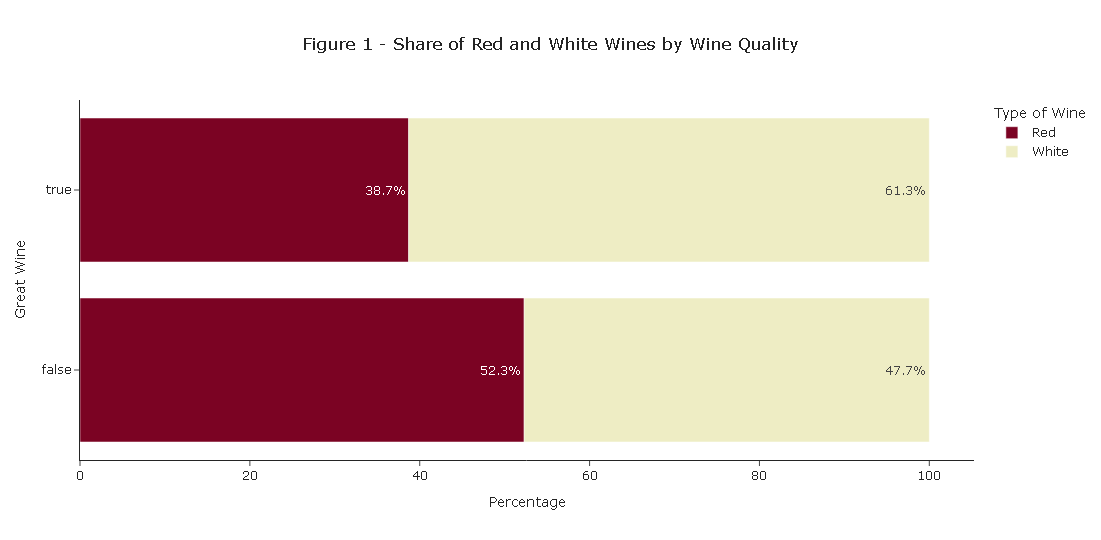

In [789]:
# Visual representation with plotly
# 1) Data of the number of wines by type and quality
data_fig_one = pd.crosstab(wines["great wine"], wines["type"]).reset_index()
data_fig_one = data_fig_one.melt(id_vars= "great wine", var_name="Type", value_name="Count")

# 2) Data that express this number in percent in the sub category of each sub-category of great wines (great wine = 0 / great wine =1)
data_fig_one_percent = pd.crosstab(wines["great wine"], wines["type"], normalize="index").reset_index()
data_fig_one_percent = data_fig_one_percent.melt(id_vars= "great wine", var_name="Type", value_name="Percent") 

data_fig_one = data_fig_one.merge(data_fig_one_percent, on = ["Type", "great wine"]).sort_values(by=["great wine"])
del data_fig_one_percent

data_fig_one["Percent"] = data_fig_one["Percent"] * 100
data_fig_one["Percent"] = data_fig_one["Percent"].round(1)

data_fig_one["Share"] = (data_fig_one["Percent"]).astype(str) + "%"

# Create the bar chart with combined text for Percent and Count
fig_one = px.bar(data_fig_one, x="Percent", y="great wine",color="Type",
                 text=data_fig_one["Share"],
                 title="Figure 1 - Share of Red and White Wines by Wine Quality",
                 labels={"great wine": "Great Wine", "Percent": "Percentage", "Type" : "Type of Wine"},
                 hover_name="Type",
                 hover_data={"Percent" : False, "Share": True, "Count": True, "Type" : False, "great wine" : False}, #Note : As in the website https://plotly.com/python/hover-text-and-formatting/, I use this code to change the tooltip/text that appear when we click on the graph. My goal is to avoid redundancy between share and percent in the hoover and to display the count.
                 color_discrete_map={"Red": "rgb(123,3,35)", "White": "rgb(238, 237, 196)"}, #I add colors that I found on internet that suppose to mimick the wine colors
                 template = "simple_white",
                 height=540,
                 width=1080) #this last line just change the theme of the graph as we can see example in https://plotly.com/python/templates/

fig_one.update_layout(hovermode="x") #line to change the kind of hover used --> I chose this one because it reads simultanously the hovers for the two type of wines.
fig_one.update_layout(title_x=0.5) #line to center the title
fig_one.show()

#To export the graph the code fig_one.write_image("Exported Graphs Library/fig1.png",scale = 12)  

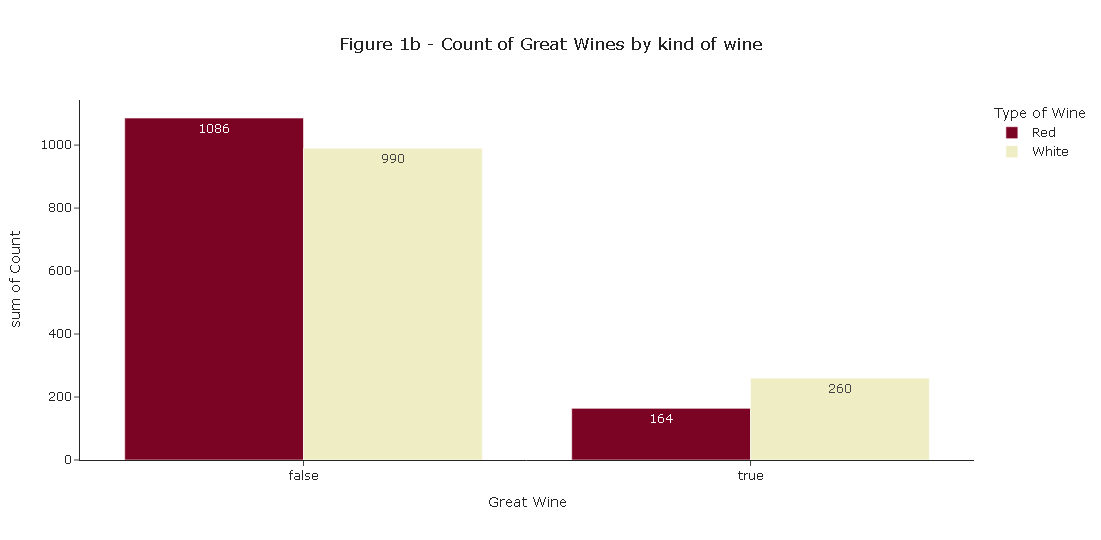

In [790]:
alt_figure_one = px.histogram(data_fig_one, x="great wine", y="Count", color ="Type", barmode="group",
                              text_auto=True,
                              title="Figure 1b - Count of Great Wines by kind of wine",
                              labels={"great wine": "Great Wine", "sum of count": "Count", "Type" : "Type of Wine"},
                              color_discrete_map={"Red": "rgb(123,3,35)", "White": "rgb(238, 237, 196)"},
                              template = "simple_white",
                              height=540,
                              width=1080)
alt_figure_one.update_layout(title_x=0.5)
alt_figure_one.show()

The share of great wines is higher in the total of white wines (21% of white wines) than in the total of red wines (13%). 

In [792]:
# Addition of percentage for row true and false of great wine
a_table_for_two_v2 = a_table_for_two[["Red","White","Total"]].transpose()

a_table_for_two_v2.rename({"False" : "0", "True" : "1"}, inplace = True)

a_table_for_two_v2.columns # We had several errors regarding the next code when we used ["False"] and ["True"] as column names. By printing the column names we realised that python wanted us to write these 2 columns without quotation marks

a_table_for_two_v2["% of False"] = a_table_for_two_v2[False]/a_table_for_two_v2["Total"]*100
a_table_for_two_v2["% of False"] = a_table_for_two_v2["% of False"].round(1)
a_table_for_two_v2["% of True"] = a_table_for_two_v2[True]/a_table_for_two_v2["Total"]*100
a_table_for_two_v2["% of True"] = a_table_for_two_v2["% of True"].round(1)

a_table_for_two_v2["% of Total"] = a_table_for_two_v2["% of False"] + a_table_for_two_v2["% of True"]
a_table_for_two_v2 = a_table_for_two_v2[["% of True", "% of False", "% of Total"]]

a_table_for_two_v2


# Paralelly, the share  of great wines is superior in the total of white wines (21% of white wines in our dataset) than in red wines.

great wine  % of True  % of False  % of Total
type                                         
Red              13.1        86.9       100.0
White            20.8        79.2       100.0
Total            17.0        83.0       100.0

## Biochemical features of wine

### A general overview

Descriptive statistics of our variables by order of coefficient of variation :


In [794]:

short_summary = wines.describe(percentiles = []) #I drop the other percentiles to make the reading easier for me

# Addition of cv : I wanted to see what variables had the biggest volatility regardless of the scale and decide to add the coefficent of variation to my summary

short_summary = short_summary.transpose()  # I invert row and columns to facilitate the computation. My differents statistics became therefore different columns.
short_summary["cv (in %)"] = short_summary["std"]/short_summary["mean"]*100
short_summary["cv (in %)"] = short_summary["cv (in %)"].round(0)
short_summary = short_summary[["min", "mean", "50%", "max", "std", "cv (in %)"]].sort_values(by=["cv (in %)"], ascending = False) #Reordering of the columns and drop of count
short_summary
# Density data seem pretty homogeneous and PH has a relatively lower coefficient of variation and std than the other features. What can be explained by the fact that most of the wines are bounded in a specific PH interval.
# The variations are the most important in residuals sugars, both sulfur dioxyd compoment and chlorid, citric acid and acid volatility




min       mean        50%        max        std  \
residual sugar        0.7000   4.220000   2.400000   23.50000   3.839540   
free sulfur dioxide   1.0000  25.452200  23.000000  289.00000  17.717002   
chlorides             0.0090   0.066762   0.059000    0.61100   0.043076   
total sulfur dioxide  6.0000  92.711000  90.000000  440.00000  60.239227   
citric acid           0.0000   0.302384   0.300000    1.00000   0.166705   
volatile acidity      0.1000   0.407888   0.360000    1.58000   0.193440   
sulphates             0.2500   0.572580   0.550000    2.00000   0.167606   
fixed acidity         4.2000   7.574620   7.200000   15.60000   1.555536   
alcohol               8.0000  10.501129  10.300000   14.00000   1.150068   
pH                    2.7400   3.255064   3.250000    4.01000   0.164223   
density               0.9874   0.995263   0.995625    1.00369   0.002775   

                      cv (in %)  
residual sugar             91.0  
free sulfur dioxide        70.0  
chlorides                  65.0  
total sulfur dioxide       65.0  
citric acid                55.0  
volatile acidity           47.0  
sulphates                  29.0  
fixed acidity              21.0  
alcohol                    11.0  
pH                          5.0  
density                     0.0

Number of rows with pH above the norm of 4 :

In [796]:
ph_above_four = wines[ wines["pH"] >= 4]
ph_above_four = pd.crosstab(ph_above_four["pH"], "N").reset_index()
ph_above_four

col_0    pH  N
0      4.01  2

Number of row with sulfur above the EU norms :

In [798]:
sulfure_above_eu_law = wines[ wines["total sulfur dioxide"] >= 400]
sulfure_above_eu_law = pd.crosstab(sulfure_above_eu_law["total sulfur dioxide"], "N").reset_index()
sulfure_above_eu_law

col_0  total sulfur dioxide  N
0                     440.0  1

### Type of wine and underlying characteristics


#### Descriptive statistics
White wines tend to have a wider  distribution concerning residual sugars than their red counterparts. The median residual sugar level in white wines is also twice that for red. 

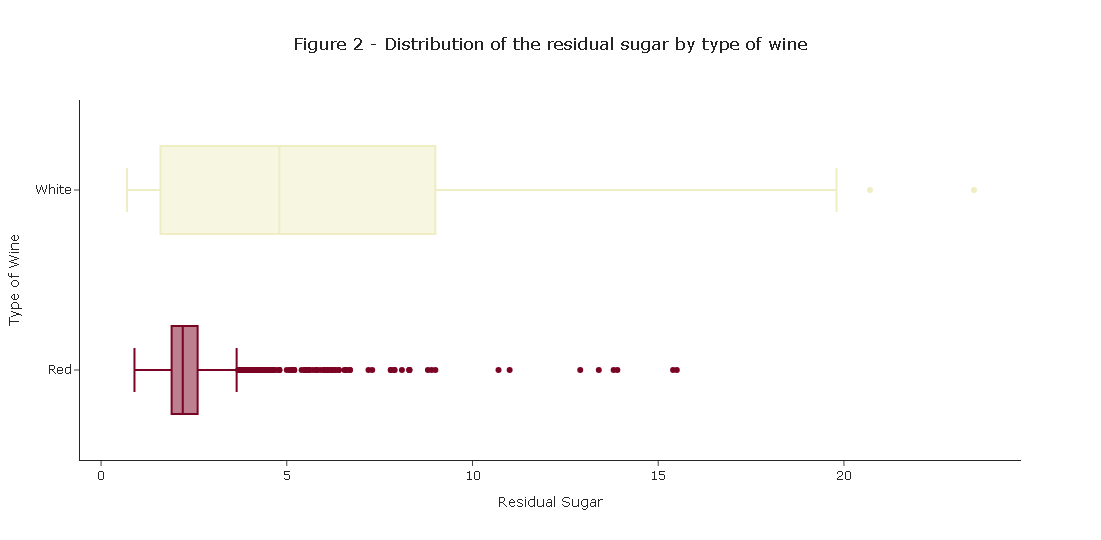

In [801]:
# Graphical representation of Residual Sugar by type of wine

box_plot_sugar = px.box(wines, x ="residual sugar", color="type", y = "type", # the use color = "type" in addition of y ="type" allow us to use or selected colors for the boxplot by type of white
                       title="Figure 2 - Distribution of the residual sugar by type of wine",
                        labels={"type" : "Type of Wine", "residual sugar" : "Residual Sugar"},
                        hover_name="type",
                        color_discrete_map={"Red": "rgb(123,3,35)", "White": "rgb(238, 237, 196)"}, 
                        template = "simple_white")

box_plot_sugar.update_layout(height=540, width = 1080)
box_plot_sugar.update_layout(title_x=0.5)
box_plot_sugar.update_layout(showlegend=False) #I hided the legend/label because the same info can be seen in the y axis
box_plot_sugar.show()

#Code to export the graph : box_plot_sugar.write_image("Exported Graphs Library/Figure 2 - Distribution of the residual sugar by type of wine.png",scale = 12)

More than all, there is far more variation in residual sugar levels in white wines. The difference between the first and third quartile for white wines is 6 times the red wines one, and its coefficient of variation is higher by 25 points.

In [803]:
sugar_mean_cv = wines.groupby("type")["residual sugar"].agg(["mean", "std"])
sugar_mean_cv["CV"] = sugar_mean_cv["std"]/sugar_mean_cv["mean"]*100
sugar_mean_cv[["CV", "mean", "std"]] = sugar_mean_cv[["CV", "mean", "std"]].round(0)
sugar_mean_cv

mean  std    CV
type                  
Red     3.0  1.0  54.0
White   6.0  5.0  79.0

Differences can be observed in total and free SO₂ levels, with white wines generally having higher levels and standard deviations. However, it is interesting to see that in terms of the coefficient of variation, i.e., standard error normalized by the mean, red wines have higher values.

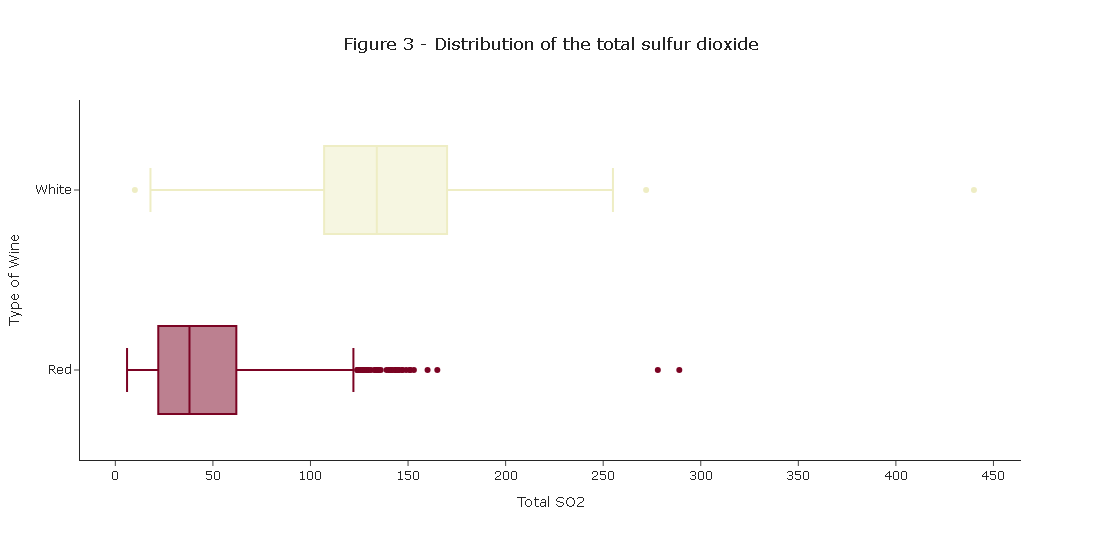

mean   std    CV
type                    
Red     47.0  33.0  71.0
White  139.0  43.0  31.0

In [805]:
# Graphical representation of Sulfur dioxide by type of wine


box_plot_S02_ttl = px.box(wines, x ="total sulfur dioxide", color="type", y = "type", 
                       title="Figure 3 - Distribution of the total sulfur dioxide",
                        labels={"type" : "Type of Wine", "total sulfur dioxide" : "Total SO2"},
                        hover_name="type",
                        color_discrete_map={"Red": "rgb(123,3,35)", "White": "rgb(238, 237, 196)"}, 
                        template = "simple_white")

box_plot_S02_ttl.update_layout(height=540, width = 1080)
box_plot_S02_ttl.update_layout(title_x=0.5)

box_plot_S02_ttl.update_layout(showlegend=False) 
box_plot_S02_ttl.show() 

#White wine tend to have in general higher level of Total SO2

SO2_mean_cv = wines.groupby("type")["total sulfur dioxide"].agg(["mean", "std"])
SO2_mean_cv["CV"] = SO2_mean_cv["std"]/SO2_mean_cv["mean"]*100
SO2_mean_cv[["CV", "mean", "std"]] = SO2_mean_cv[["CV", "mean", "std"]].round(0)
SO2_mean_cv
#The variation (std) is also more important for white wines.

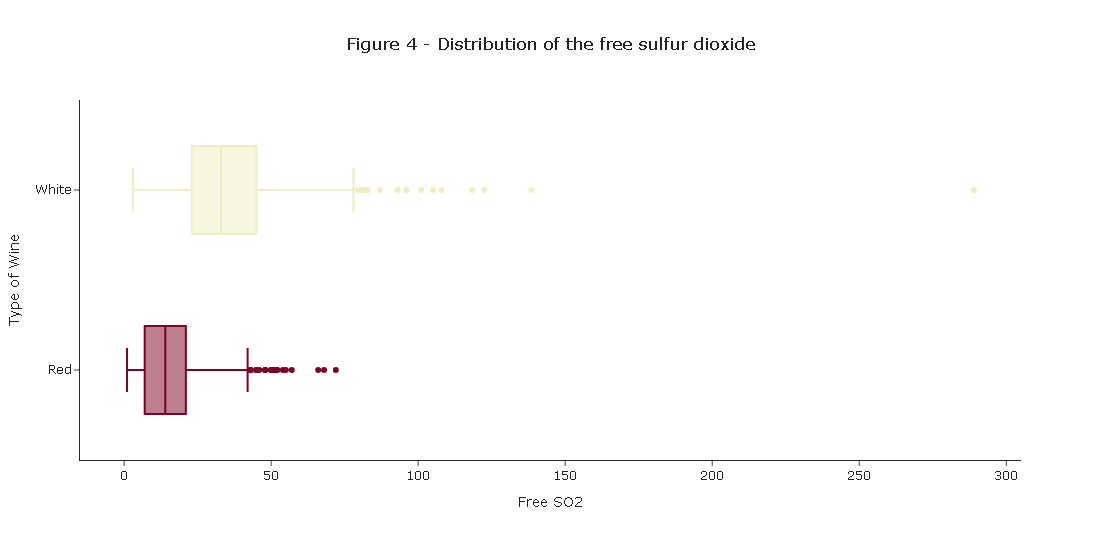

mean   std    CV
type                   
Red    16.0  10.0  70.0
White  35.0  18.0  31.0

In [806]:
# Graphical representation of free Sulfur dixoide by type of wine


box_plot_S02_free = px.box(wines, x ="free sulfur dioxide", color="type", y = "type", 
                           title="Figure 4 - Distribution of the free sulfur dioxide",
                           labels={"type" : "Type of Wine", "free sulfur dioxide" : "Free SO2"},
                           hover_name="type",
                           color_discrete_map={"Red": "rgb(123,3,35)", "White": "rgb(238, 237, 196)"},  template = "simple_white")

box_plot_S02_free.update_layout(height=540, width = 1080)
box_plot_S02_free.update_layout(title_x=0.5)

box_plot_S02_free.update_layout(showlegend=False) 
box_plot_S02_free.show() 



SO2_free_mean_cv = wines.groupby("type")["free sulfur dioxide"].agg(["mean", "std"])
SO2_free_mean_cv["CV"] = SO2_mean_cv["std"]/SO2_mean_cv["mean"]*100
SO2_free_mean_cv[["CV", "mean", "std"]] = SO2_free_mean_cv[["CV", "mean", "std"]].round(0)
SO2_free_mean_cv
#Similar analysis for the free sulfur dioxide

For some variables, it is not only the center of the distribution but also its general shape, which differs from the two types of wines. 
It is notably true for citric acid :

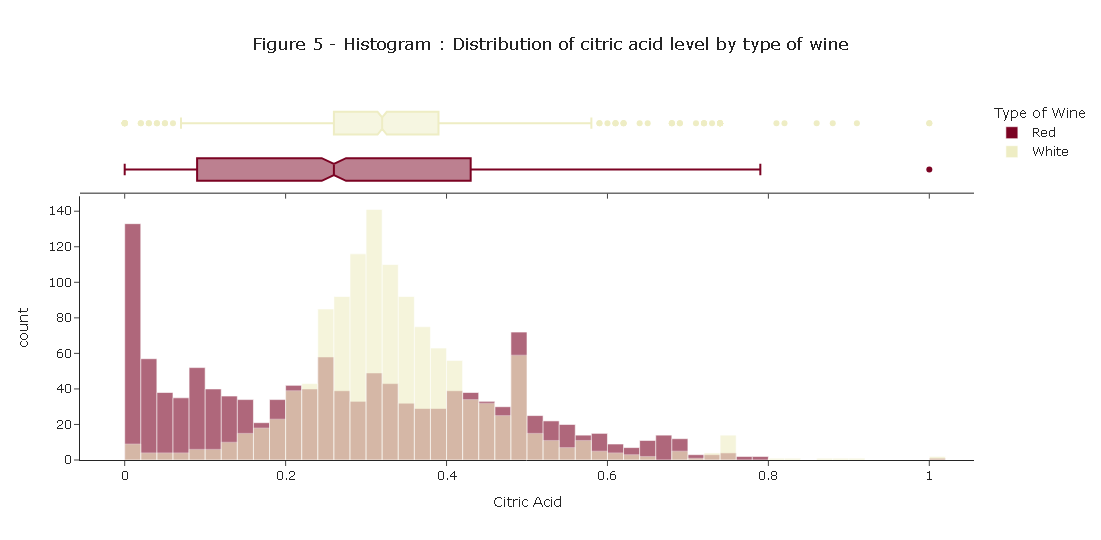

In [808]:
hist_citric_acid = px.histogram(wines, x="citric acid", color="type", marginal="box",
                   title="Figure 5 - Histogram : Distribution of citric acid level by type of wine",
                   labels={"type" : "Type of Wine", "citric acid" : "Citric Acid"},
                   color_discrete_map={"Red": "rgb(123,3,35)", "White": "rgb(238, 237, 196)"}, 
                    opacity=0.6,
                    category_orders={"type": ["Red", "White"]}, #We use it to change the order of the histogram in the layout like in https://plotly.com/python/styling-plotly-express/ because the red bars tend to hide their counterparts.
                   template = "simple_white")
hist_citric_acid.update_layout(height=540)
hist_citric_acid.update_layout(title_x=0.5)
hist_citric_acid.update_layout(barmode='overlay')
hist_citric_acid.show()

Seemingly, differences in the distribution are also observed in other variables such as volatile acidity level but also with the SO2 variables and the density. The code below is an interactive dashboard allowing to see the distribution for each numeric variable :

In [810]:
#This code takes inspiration from https://dash.plotly.com/tutorial (notably to the section "My First App with Data, Graph, and Controls")
#And to the section "Combined statistical representations in Dash" from https://plotly.com/python/distplot/#combined-statistical-representations-in-dash

numeric_values = wines.columns.drop(["type", "great wine"]) 

app = Dash(__name__)

app.layout = [html.Div([
    html.H3("Figure 6 - Interactive histogram of the variables by type of wine"),
    html.P("Select your variable of interest :"),
    dcc.RadioItems(options=numeric_values,
        value="volatile acidity",
        inline=True,
        id="button_for_variable")]),

    html.Div(children=[dcc.Graph(figure={}, id='histo-chart-final')])]

@callback(
        Output(component_id='histo-chart-final', component_property='figure'),
        Input(component_id="button_for_variable", component_property='value'))

def update_graph(variable_of_interest):
    fig = px.histogram(wines, x=variable_of_interest, color="type",
                    title= "Distribution of " + variable_of_interest,
                   labels={"type" : "Type of Wine"},
                   color_discrete_map={"Red": "rgb(123,3,35)", "White": "rgb(238, 237, 196)"}, 
                    opacity=0.6,
                    category_orders={"type": ["Red", "White"]}, 
                   template = "simple_white")
    fig.update_layout(barmode='overlay')

    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=2223) # This option with port is optional. I used it because the code did not run on my pc because another dash that I tried seem to use the same default port.

              


Descriptive statistics on the two samples seem to indicate important differences in the mean of our two subsamples. The table below gives, for each variable, its mean and standard deviation (column "Statistics") for red and white wines. It also computes the difference between the two means and the difference in percent. The latter is equal to the difference (Mean of red wines - Mean of white wines) divided by the mean of white wines. This measure was created to facilitate the comparison between the different variables by eliminating the scale differences in their measurements.

In [812]:
# A comparaison between the main characteristics of the types of wine
numeric_values = wines.columns.drop(["type", "great wine"]) 
a_bottle_ticket = wines.groupby("type")[numeric_values].agg(["mean", "std"]).transpose().reset_index()
a_bottle_ticket["Difference in percent"] = (a_bottle_ticket["Red"] - a_bottle_ticket["White"]) / a_bottle_ticket["White"]*100#this column is used to look at which variables know potentially the biggest gap. 
a_bottle_ticket["Difference (raw value)"] = a_bottle_ticket["Red"] - a_bottle_ticket["White"]
a_bottle_ticket["Difference in percent"] = a_bottle_ticket["Difference in percent"].round(1)
a_bottle_ticket["Difference (raw value)"] = a_bottle_ticket["Difference (raw value)"].round(1) 
a_bottle_ticket = a_bottle_ticket.sort_values(by="Difference in percent")
a_bottle_ticket.columns =  ["Variable", "Statistics", "Red", "White", "Difference in percent", "Difference (raw value)"] # I use it artinatively to rename() that seem not to work for the column generate automatically by pandas (level_0 and level_1)
a_bottle_ticket = a_bottle_ticket.sort_values(by = ["Statistics", "Difference in percent"])
a_bottle_ticket
#In average red wine seem to have more chlorides volatile acidity than white wines while the latter tend to be sweeter (have more residual sugar) and have more sulfur dioxide.


Variable Statistics        Red       White  \
12  total sulfur dioxide       mean  46.505200  138.916800   
6         residual sugar       mean   2.535840    5.904160   
10   free sulfur dioxide       mean  15.821600   35.082800   
4            citric acid       mean   0.271344    0.333424   
20               alcohol       mean  10.424747   10.577512   
14               density       mean   0.996726    0.993801   
16                    pH       mean   3.310656    3.199472   
0          fixed acidity       mean   8.300640    6.848600   
18             sulphates       mean   0.657456    0.487704   
2       volatile acidity       mean   0.530932    0.284844   
8              chlorides       mean   0.087600    0.045925   
7         residual sugar        std   1.371302    4.683817   
11   free sulfur dioxide        std  10.410287   18.276109   
15               density        std   0.001859    0.002770   
13  total sulfur dioxide        std  33.105470   43.486682   
21               alcohol        std   1.074939    1.216223   
17                    pH        std   0.154540    0.154569   
19             sulphates        std   0.170015    0.113498   
5            citric acid        std   0.195786    0.123867   
3       volatile acidity        std   0.183590    0.104205   
1          fixed acidity        std   1.721605    0.906833   
9              chlorides        std   0.048383    0.022417   

    Difference in percent  Difference (raw value)  
12                  -66.5                   -92.4  
6                   -57.0                    -3.4  
10                  -54.9                   -19.3  
4                   -18.6                    -0.1  
20                   -1.4                    -0.2  
14                    0.3                     0.0  
16                    3.5                     0.1  
0                    21.2                     1.5  
18                   34.8                     0.2  
2                    86.4                     0.2  
8                    90.7                     0.0  
7                   -70.7                    -3.3  
11                  -43.0                    -7.9  
15                  -32.9                    -0.0  
13                  -23.9                   -10.4  
21                  -11.6                    -0.1  
17                   -0.0                    -0.0  
19                   49.8                     0.1  
5                    58.1                     0.1  
3                    76.2                     0.1  
1                    89.8                     0.8  
9                   115.8                     0.0

#### Statistical tests

We wanted to conduct a statistical test to see whether differences in mean for each variable was statistically significant. As a first step, we conduct a normal test in order to decide whether our main test should be a parametric or, by precaution, a non-parametric one. Our choice took roots in the fact that, in a study of 2015 on the difference in wines' chloride level, Coli et al. found that their data on chloride, for example, was characterized by :
- large standard deviation
- asymmetry
- outliers
- and a non-normal distribution.

We therefore conduct on each variable and for all types of wines 2 tests : the Anderson test and the Shapiro one. 
The results for the red wines subsample is below : 

In [814]:
#The previous value are only descriptive statistics. We will try to see if the values are significatively different.
# Step 1 - normality test (this section is inspired by https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/)



red_wines = wines[wines["type"] == "Red"].drop("type", axis = 1)
white_wines = wines[wines["type"] == "White"].drop("type", axis = 1)





def shapiro_test(column):
    return shapiro(column)



def intepretation_shapiro(pvalue):
    if pvalue  >=0.05:
        return "Normal (can not reject H0)"
    else:
        return "Reject H0"

shapiro_test_red = red_wines.drop("great wine", axis = 1)
shapiro_test_red = pd.DataFrame(shapiro_test_red.apply(shapiro_test)).transpose()
shapiro_test_red.columns = ["Shapiro Statistics", "Shapiro p-value"]
    
shapiro_test_red["Shapiro Interpretation"] = shapiro_test_red["Shapiro p-value"].apply(intepretation_shapiro)
shapiro_test_red = shapiro_test_red.reset_index()

def anderson_test(column):
    return normaltest(column)



def intepretation_anderson(pvalue):
    if pvalue  >=0.05:
        return "Normal (can not reject H0)"
    else:
        return "Reject H0"

anderson_test_red = red_wines.drop("great wine", axis = 1)
anderson_test_red = pd.DataFrame(anderson_test_red.apply(anderson_test)).transpose()
anderson_test_red.columns = ["Anderson Statistics", "Anderson p-value"]
    
anderson_test_red["Anderson Interpretation"] = anderson_test_red["Anderson p-value"].apply(intepretation_anderson)

anderson_test_red = anderson_test_red.reset_index()


normal_tests_red = shapiro_test_red.merge(anderson_test_red, on = "index")
del anderson_test_red
del shapiro_test_red

normal_tests_red_to_print = normal_tests_red.drop(["Shapiro Statistics", "Anderson Statistics"], axis = 1)
normal_tests_red_to_print





index  Shapiro p-value Shapiro Interpretation  \
0          fixed acidity     1.105646e-20              Reject H0   
1       volatile acidity     1.530893e-15              Reject H0   
2            citric acid     3.699606e-19              Reject H0   
3         residual sugar     8.643745e-48              Reject H0   
4              chlorides     5.463288e-51              Reject H0   
5    free sulfur dioxide     2.286207e-27              Reject H0   
6   total sulfur dioxide     5.514778e-31              Reject H0   
7                density     7.227174e-06              Reject H0   
8                     pH     1.032785e-05              Reject H0   
9              sulphates     7.761063e-35              Reject H0   
10               alcohol     3.525005e-24              Reject H0   

    Anderson p-value Anderson Interpretation  
0       7.531595e-33               Reject H0  
1       3.988738e-29               Reject H0  
2       3.467097e-25               Reject H0  
3      1.697342e-262               Reject H0  
4      8.271139e-307               Reject H0  
5       1.027581e-57               Reject H0  
6       8.014148e-91               Reject H0  
7       5.275462e-05               Reject H0  
8       1.065142e-07               Reject H0  
9      3.658033e-159               Reject H0  
10      1.197601e-24               Reject H0

The results on the white wine's subsample is similar.

In [816]:
# Step 1b- Normality test for white wine subsample
shapiro_test_white = white_wines.drop("great wine", axis = 1)
shapiro_test_white = pd.DataFrame(shapiro_test_white.apply(shapiro_test)).transpose()
shapiro_test_white.columns = ["Shapiro Statistics", "Shapiro p-value"]
    
shapiro_test_white["Shapiro Interpretation"] = shapiro_test_white["Shapiro p-value"].apply(intepretation_shapiro)
shapiro_test_white = shapiro_test_white.reset_index()

anderson_test_white = white_wines.drop("great wine", axis = 1)
anderson_test_white = pd.DataFrame(anderson_test_white.apply(anderson_test)).transpose()
anderson_test_white.columns = ["Anderson Statistics", "Anderson p-value"]
    
anderson_test_white["Anderson Interpretation"] = anderson_test_white["Anderson p-value"].apply(intepretation_anderson)

anderson_test_white = anderson_test_white.reset_index()


normal_tests_white = shapiro_test_white.merge(anderson_test_white, on = "index")
del anderson_test_white
del shapiro_test_white

normal_tests_white_to_print = normal_tests_red.drop(["Shapiro Statistics", "Anderson Statistics"], axis = 1)
normal_tests_white_to_print

# Both the red wines' and white wines' subsamples seem to have variables that does not follow normal distriubtion. We will therefore use non parametric tests.

index  Shapiro p-value Shapiro Interpretation  \
0          fixed acidity     1.105646e-20              Reject H0   
1       volatile acidity     1.530893e-15              Reject H0   
2            citric acid     3.699606e-19              Reject H0   
3         residual sugar     8.643745e-48              Reject H0   
4              chlorides     5.463288e-51              Reject H0   
5    free sulfur dioxide     2.286207e-27              Reject H0   
6   total sulfur dioxide     5.514778e-31              Reject H0   
7                density     7.227174e-06              Reject H0   
8                     pH     1.032785e-05              Reject H0   
9              sulphates     7.761063e-35              Reject H0   
10               alcohol     3.525005e-24              Reject H0   

    Anderson p-value Anderson Interpretation  
0       7.531595e-33               Reject H0  
1       3.988738e-29               Reject H0  
2       3.467097e-25               Reject H0  
3      1.697342e-262               Reject H0  
4      8.271139e-307               Reject H0  
5       1.027581e-57               Reject H0  
6       8.014148e-91               Reject H0  
7       5.275462e-05               Reject H0  
8       1.065142e-07               Reject H0  
9      3.658033e-159               Reject H0  
10      1.197601e-24               Reject H0

Because of these results, we use a non-parametric Mann and Whitney U test to appraise the significance of the difference in means between the two kinds of wines.

In [818]:
#Step 2 - Use Mann and Whitney U test : This test will be use to see whether the features between red and white wines are statistically different. 
# The code take inspiration from : https://www.geeksforgeeks.org/mann-and-whitney-u-test/
for variable in numeric_values :
    stat, p_value = mannwhitneyu(red_wines[variable], white_wines[variable], alternative="two-sided")
    print("   - " + variable.title() + " : p-value = %.2f" % (p_value)) #.title() is used for formatting reasons. I use it to transform the first letters of each word in majuscule
# The distribution is statiscally different between our two populations (red and white wines).

   - Fixed Acidity : p-value = 0.00
   - Volatile Acidity : p-value = 0.00
   - Citric Acid : p-value = 0.00
   - Residual Sugar : p-value = 0.00
   - Chlorides : p-value = 0.00
   - Free Sulfur Dioxide : p-value = 0.00
   - Total Sulfur Dioxide : p-value = 0.00
   - Density : p-value = 0.00
   - Ph : p-value = 0.00
   - Sulphates : p-value = 0.00
   - Alcohol : p-value = 0.01


Statistical differences are found for all numeric variables. 

The graph below is a graphical representation of the mean for our two subpopulations.

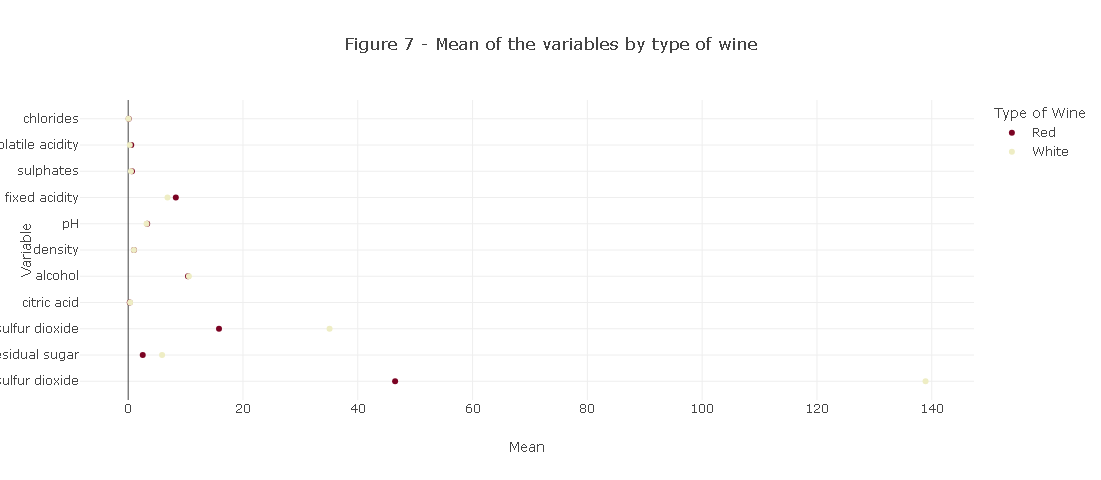

In [820]:
stats_for_scatter_plot = a_bottle_ticket[a_bottle_ticket["Statistics"] == "mean"].drop("Statistics", axis =1)
stats_for_scatter_plot = stats_for_scatter_plot.melt(["Variable", "Difference (raw value)", "Difference in percent"], var_name = "type", value_name = "Mean")

stats_for_scatter_plot = px.scatter(stats_for_scatter_plot, x="Mean", y="Variable", color="type",
                   title="Figure 7 - Mean of the variables by type of wine",
                   labels={"type" : "Type of Wine"},
                   hover_name="type",
                  hover_data={"Variable" : True, "Mean": True, "type" : False},
                   color_discrete_map={"Red": "rgb(123,3,35)", "White": "rgb(238, 237, 196)"},
                  template = "none") #here we change the template to keep a white background but display the background's lines for aestetich value
stats_for_scatter_plot.update_layout(height=480)
stats_for_scatter_plot.update_layout(title_x=0.5)

stats_for_scatter_plot.show()

To summarize our findings, the following graph displays the difference in percent between the two means.

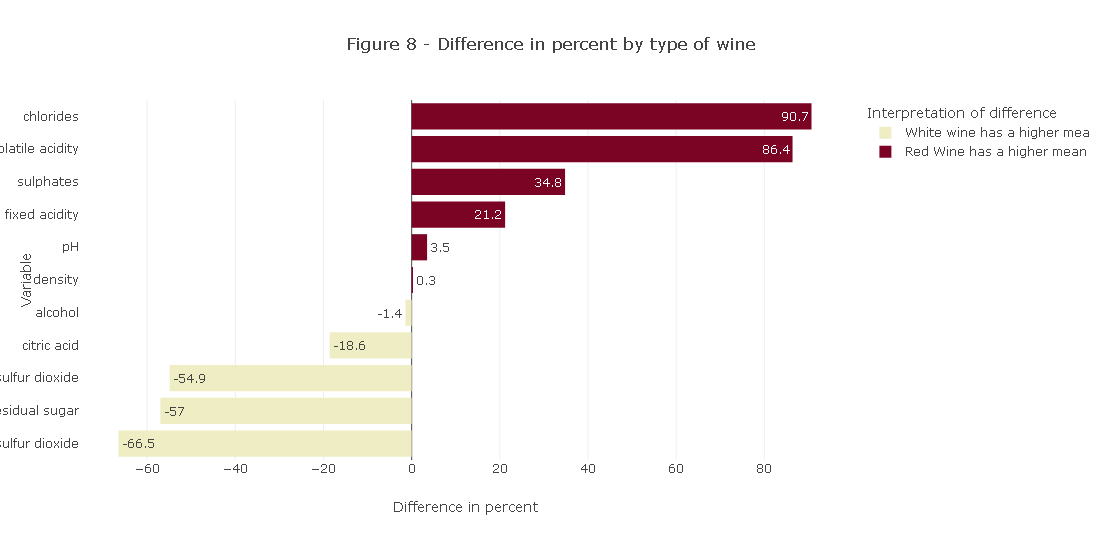

In [822]:
def interpretation_difference(difference):
    if difference  >=0:
        return "Red Wine has a higher mean"
    else:
        return "White wine has a higher mean"

lets_go_to_the_bar = a_bottle_ticket
lets_go_to_the_bar["Interpretation of difference"] = lets_go_to_the_bar["Difference (raw value)"].apply(interpretation_difference) #as a reminder, this table contains the mean of red and whites wine for each variable, their difference and their difference in percent.

lets_go_to_the_bar = px.bar(lets_go_to_the_bar[lets_go_to_the_bar["Statistics"] == "mean"], x="Difference in percent", y="Variable", color = "Interpretation of difference", 
                   title="Figure 8 - Difference in percent by type of wine",
                    text="Difference in percent",
                   color_discrete_map={"Red Wine has a higher mean": "rgb(123,3,35)", "White wine has a higher mean": "rgb(238, 237, 196)"},
                  template = "none")
lets_go_to_the_bar.update_layout(height=540)
lets_go_to_the_bar.update_layout(title_x=0.5)

lets_go_to_the_bar.show()

#Export lets_go_to_the_bar.write_image("Exported Graphs Library/Difference in percent by type of wine.png",scale = 12)

As a first insight in the variation in means regarding both type of wines and wine's quality, we created a table of the mean with each numerical values : 

In [824]:
## trying to see average range for each variable to type of wine and if there are big differences in values that make a great wine  
each_wine_avg = wines.groupby(["type", "great wine"]).aggregate(
       alcohol = ("alcohol", "mean"),
       sulphates = ("sulphates", "mean"),
       pH = ("pH", "mean"),
       free_sulfur_dioxide = ("free sulfur dioxide", "mean"),
       volatile_acidity = ("volatile acidity", "mean"),
       residual_sugar = ("residual sugar", "mean"),
       fixed_acidity = ("fixed acidity", "mean"),
       total_sulfur_dioxide = ("total sulfur dioxide", "mean"),
       citric_acid = ("citric acid", "mean"),
       density = ("density", "mean"),
       chlorides = ("chlorides", "mean")  
    ).T

each_wine_avg.to_csv('Exported Graphs Library/each_wine_average.csv', header=True, index=True, encoding='utf-8')

each_wine_avg



type                        Red                  White            
great wine                False      True        False       True 
alcohol               10.248910  11.589126   10.331495   11.514269
sulphates              0.644291   0.744634    0.486010    0.494154
pH                     3.314705   3.283841    3.187626    3.244577
free_sulfur_dioxide   16.107735  13.926829   35.380303   33.950000
volatile_acidity       0.549365   0.408872    0.289460    0.267269
residual_sugar         2.501842   2.760976    6.241212    4.620769
fixed_acidity          8.216759   8.856098    6.907828    6.623077
total_sulfur_dioxide  48.249079  34.957317  143.121212  122.907692
citric_acid            0.255175   0.378415    0.334747    0.328385
density                0.996839   0.995973    0.994265    0.992033
chlorides              0.089272   0.076530    0.047769    0.038904

## Analysis of the corelation between variables

In the previous section, we studied together the general distribution of our different variables. This part of the report will focus of the relationship that exists between our variables. Taking into account the significance of the differences that exist in the subsample (red and white wines). We decided to study this relationship independently for the two subpopulations and not the whole dataset. The figure below is the correlation matrices of all variables (numeric and qualitative) for the two different kinds of wine. Some correlations arise from the nature of the data. For example, total SO₂  and free SO₂   are strongly correlated, as total SO₂  is the sum of free and bound SO₂. However, it is interesting to note that the magnitude and, sometimes, the sign of some "natural" correlations shifts between red and white wines.

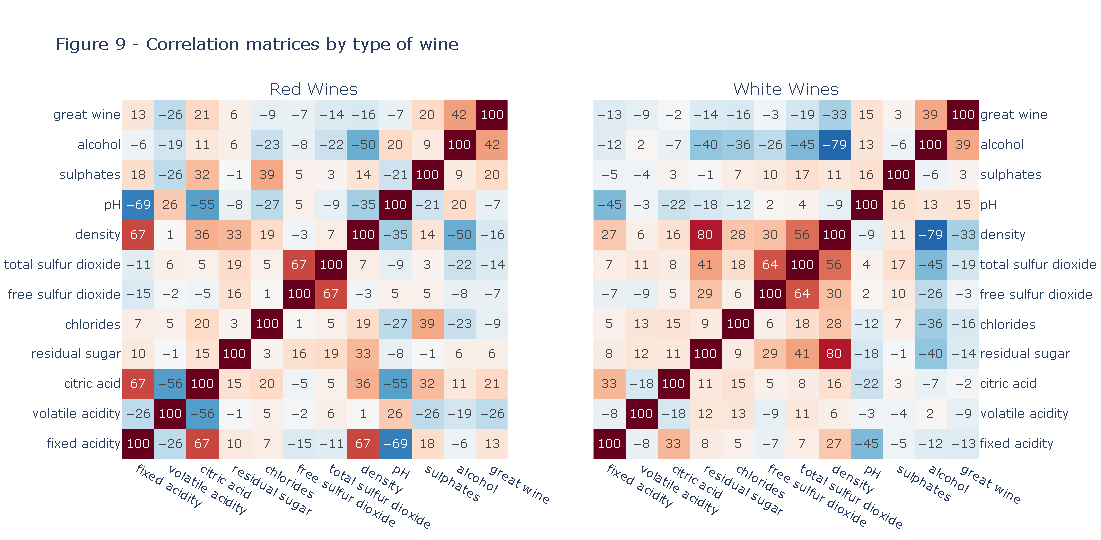

In [827]:
# The codes of this section are inspired by :
# https://plot.ly/python/subplots/, 
# https://plotly.com/python/imshow/, 
# https://community.plotly.com/t/combining-ready-made-figures-into-one-with-separation-by-color/72711/10,
# and https://plotly.com/python/colorscales/.

hot_wine_hot_map_Red = px.imshow((wines[wines["type"] == "Red"].corr(numeric_only=True)*100).round(0),
                                 color_continuous_scale="RdBu_r",
                                text_auto = True)

hot_wine_hot_map_White = px.imshow((wines[wines["type"] == "White"].corr(numeric_only=True)*100).round(0),
                                 color_continuous_scale="RdBu_r",
                                text_auto = True)


hot_wine_hot_map_v2 = make_subplots(rows = 1, cols = 2, subplot_titles=("Red Wines", "White Wines"))


hot_wine_hot_map_v2.add_trace(hot_wine_hot_map_Red['data'][0],1,1)
hot_wine_hot_map_v2.add_trace(hot_wine_hot_map_White['data'][0],1,2)

hot_wine_hot_map_v2.update_layout(height=540, width=1000, 
                                  title_text="Figure 9 - Correlation matrices by type of wine",
                                  coloraxis=dict(colorscale='RdBu_r', cmid=0))

hot_wine_hot_map_v2.update_yaxes(side= "right", row=1, col=2) #this line of code just put the y axis on the left, the code below hide the colorscale/legend. These 2 options are used to make the coefficient matrix more readable (some information overlapped if these options are not added)
hot_wine_hot_map_v2.update_coloraxes(showscale=False)
hot_wine_hot_map_v2.show()

# hot_wine_hot_map_v2.write_image("Exported Graphs Library/Correlation matrices by type of wine.png",scale = 12)

Following the results from the correlation matrice, we also ploted scatter plots to study some key correlations :

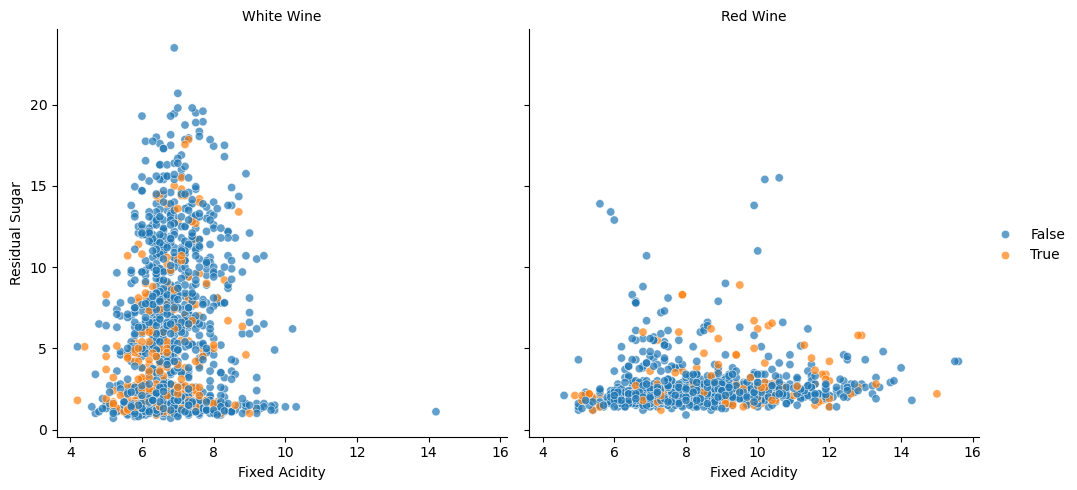

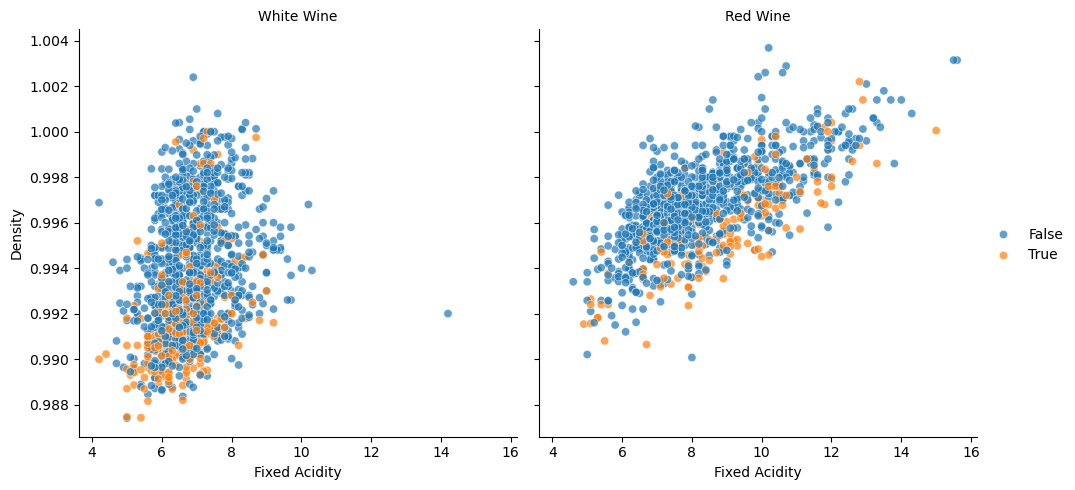

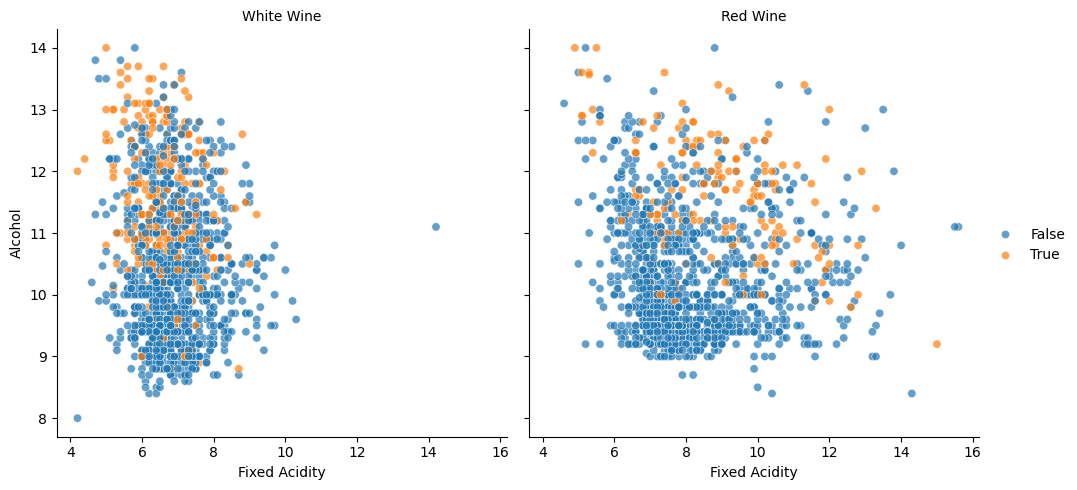

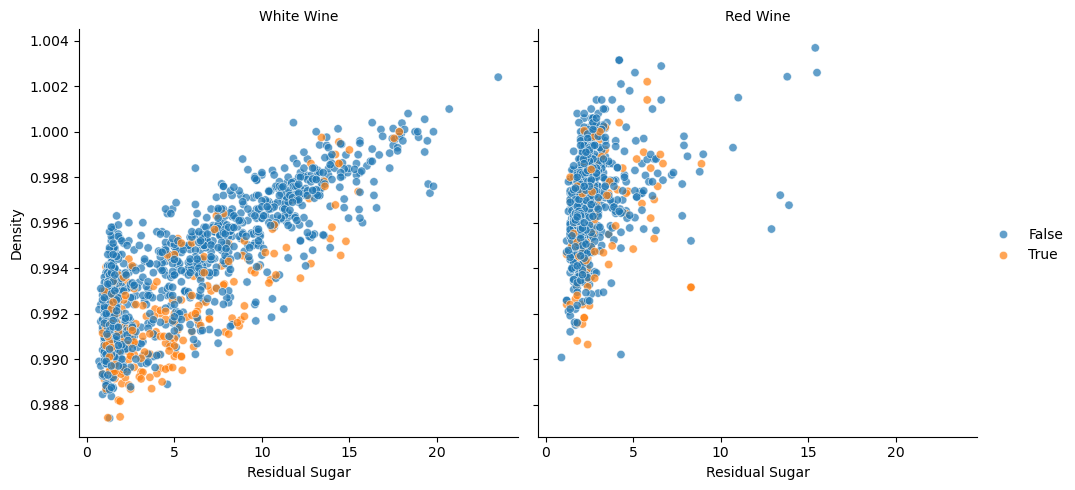

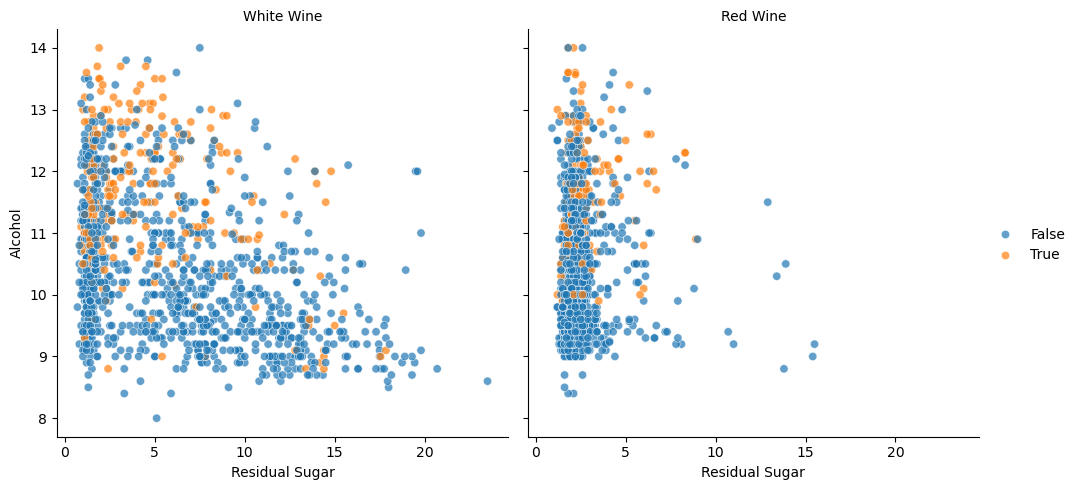

In [ ]:
## trying to a build a fucntion that looks at different combinations for red and white wine separately

correlation_variables = ['fixed acidity', 'residual sugar', 'density', 'alcohol']

def plot_facet_grid(data, x_var, y_var):
    fig2 = sns.FacetGrid(data, col="type", height=5, aspect=1)
    fig2.map_dataframe(sns.scatterplot, x=x_var, y=y_var, hue="great wine", alpha=0.7)
    fig2.set_axis_labels(x_var.replace("_", " ").title(), y_var.replace("_", " ").title())
    fig2.set_titles("{col_name} Wine")
    fig2.add_legend()

    plt.show()

for i in range(len(correlation_variables)):
    for j in range(i + 1, len(correlation_variables)):
        x_var = correlation_variables[i]
        y_var = correlation_variables[j]
        plot_facet_grid(wines, x_var, y_var)

The correlation between the binary variable great wine and the other numerical variables also changes from red to white wines. To focus on this correlation, the figure below provides a graphical representation of the correlation coefficients using the point-biserial correlation coefficient, which is particularly suited when one of the variables is binary. 

In [ ]:
pointbi_red2 = red_wines[numeric_values].corrwith(red_wines["great wine"], method=stats.pointbiserialr).transpose().reset_index()
pointbi_red2.columns = ["Variable","Coefficient of Correlation (in %)", "P-value"]
pointbi_red2["Type"] = "Red"


pointbi_white2 = white_wines[numeric_values].corrwith(white_wines["great wine"], method=stats.pointbiserialr).transpose().reset_index()
pointbi_white2.columns = ["Variable","Coefficient of Correlation (in %)", "P-value"]
pointbi_white2["Type"] = "White"

pointbi_final = pd.concat([pointbi_red2, pointbi_white2])

pointbi_final["Coefficient of Correlation (in %)"] = (pointbi_final["Coefficient of Correlation (in %)"]*100).round(0)
pointbi_final["P-value"] = (pointbi_final["P-value"]).round(2)

point_bi_fig = px.bar(pointbi_final, x="Variable", y="Coefficient of Correlation (in %)", color="Type", barmode="group",
                      title="Figure 10 - Coefficient of correlation with Great Wine binary variable (using point biserial correlation coefficient)",
                      text="Coefficient of Correlation (in %)",
                      hover_name="Type",
                      hover_data={"Type" : False, "Coefficient of Correlation (in %)": True, "Variable": True, "P-value" : True}, 
                      color_discrete_map={"Red": "rgb(123,3,35)", "White": "rgb(238, 237, 196)"},
                      template = "none",
                      height = 540
                     )
point_bi_fig.update_xaxes(categoryorder='total descending')

point_bi_fig.show()

# point_bi_fig.write_image("Exported Graphs Library/Coefficient of correlation with Great Wine binary variable (using point biserial correlation coefficient).png",scale = 12)

## Explanatory Analysis - Characteristics of a “great wine”

In this last part, we use probit regressions with “great wine” as a binary “explained variable”. Because of the observations that we made during the previous part, we chose to treat red and white wines as two different populations and conduct for each wine a probit model. Some variables were not included in the regression because of their strong collinearity with other variables would have violated classical econometric assumptions and give a spurious correlation. Total sulfur dioxide was for example dropped because it is a function of total sulfur dioxide and bound sulfur dioxide. Similarly, fixed acidity was also dropped for being a function of volatile acidity. The results of the regression for the red wines' subsample appear in the table below.

In [ ]:
# Inspiration for the code : https://medium.com/@polanitzer/the-probit-model-in-python-predict-default-among-u-s-corporates-c0f32cb4b5c2
Y = red_wines["great wine"]
X = red_wines.drop(["great wine", "total sulfur dioxide", "fixed acidity"], axis=1) 
#total sulfur dioxid is drop because it is a function of total sulfur dioxid and bound sulfur dioxid. Keeping it would have violated classical econometric assumptions and give a spurious correlation between its free component and the explained variable.
#fixed acidity was also drop for also being a function of volatile acidity
X = sm.add_constant(X)
model = sm.Probit(Y, X)
probit_model = model.fit()
probit_model.summary()

The results for the white wines' subsample are described in the following table.

In [ ]:
Y2 = white_wines["great wine"]
X2 = white_wines.drop(["great wine", "total sulfur dioxide", "fixed acidity"], axis=1) #total sulfur dioxid is drop because it is a function of total sulfur dioxid and bound sulfur dioxid. Keeping it would have violated classical econometric assumptions and give a spurious correlation between its free component and the explained variable.
X2 = sm.add_constant(X2)
model2 = sm.Probit(Y2, X2)
probit_model2 = model2.fit()
probit_model2.summary()

## Machine Learning Model
The motivation and source of codes and parameters is strongly inspired by our Machine Learning course with Fabrice Rossi

In [ ]:
## split data to create separate data sets
red_wine = wines[wines["type"] == "Red"].drop("type", axis = 1)
white_wine = wines[wines["type"] == "White"].drop("type", axis = 1)

In [ ]:
## cleaning the variables
## making sure that the 'great wine' variable is considered as a numerical variable for a binary classification
red_wine['great wine'] = red_wine['great wine'].astype("float")
white_wine['great wine'] = white_wine['great wine'].astype("float")

## a list of numerical variables to consider as inputs
numerical_columns = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
                     'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                     'pH', 'sulphates', 'alcohol']

In [ ]:
## necessary packages for our Decision Tree, Optimised Decision Tree and Random Forests 

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

In [ ]:
## input and output variable
X_red = red_wine[numerical_columns] ## input
y_red = red_wine['great wine'] ## output or target

X_white = white_wine[numerical_columns] ## input
y_white = white_wine['great wine'] ## output or targe

## data split
X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, y_red, test_size=0.2, random_state=42)
X_white_train, X_white_test, y_white_train, y_white_test = train_test_split(X_white, y_white, test_size=0.2, random_state=42)

In [ ]:

# Simple Decision Tree Classifier (without parameters specification)
model = DecisionTreeClassifier(random_state=42)
model.fit(X_red_train, y_red_train)
model.fit(X_white_train, y_white_train)

# predictions on test set
y_red_pred = model.predict(X_red_test)
y_white_pred = model.predict(X_white_test)

# model evaluation
print("Classification Report for Red Wine:\n", classification_report(y_red_test, y_red_pred))
print("Accuracy Score for Red Wine:", accuracy_score(y_red_test, y_red_pred))

print("Classification Report for White Wine:\n", classification_report(y_white_test, y_white_pred))
print("Accuracy Score for White Wine:", accuracy_score(y_white_test, y_white_pred))

target_names = ['Not Great', 'Great']
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Red Wine Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_red_test, y_red_pred, ax=axes[0])
axes[0].xaxis.set_ticklabels(target_names)
axes[0].yaxis.set_ticklabels(target_names)
axes[0].set_title("Red Wine: Confusion Matrix for Decision Tree Classifier")

# White Wine Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_white_test, y_white_pred, ax=axes[1])
axes[1].xaxis.set_ticklabels(target_names)
axes[1].yaxis.set_ticklabels(target_names)
axes[1].set_title("White Wine: Confusion Matrix for Decision Tree Classifier")

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
## parameters specification of the decision tree model
## we use the understanding from our Machine Learning course and play with some numbers. For example, cv_folds = 5 because we think the data is not that big
param_grid = {'max_depth': range(1, 20),
'min_samples_split': [2, 10, 25, 50, 75, 85, 100, 200]}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)

In [ ]:
# Decision Tree Classifier with GridSearch for optimal parameters
grid_search.fit(X_red_train, y_red_train)

# training model on the train set
best_model_red = grid_search.best_estimator_
best_model_red.fit(X_red_train, y_red_train)

# Predictions and evaluation
y_red_pred = best_model_red.predict(X_red_test)

# Optional: Plot the decision tree (for smaller trees)
# https://scikit-learn.org/1.5/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py
plt.figure(figsize=(20, 5))
plot_tree(best_model_red, feature_names=numerical_columns, class_names=['Not Great', 'Great'], filled=True, rounded=True)
plt.savefig("Exported Graphs Library/decision_tree_red_wine.png")
plt.show()

In [ ]:
# Initialize Decision Tree Classifier with GridSearch for optimal parameters
grid_search.fit(X_white_train, y_white_train)

# training model on the train set
best_model_white = grid_search.best_estimator_
best_model_white.fit(X_white_train, y_white_train)

# Predictions and evaluation
y_white_pred = best_model_white.predict(X_white_test)

# Optional: Plot the decision tree (for smaller trees)
# https://scikit-learn.org/1.5/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py
plt.figure(figsize=(20, 5))
plot_tree(best_model_white, feature_names=numerical_columns, class_names=['Not Great', 'Great'], filled=True, rounded=True)
plt.savefig("Exported Graphs Library/decision_tree_white_wine.png")
plt.show()

In [ ]:
# https://scikit-learn.org/1.5/modules/cross_validation.html
cv_scores_red = cross_val_score(best_model_red, X_red, y_red, cv=5)
cv_scores_white = cross_val_score(best_model_white, X_white, y_white, cv=5)

# Create a DataFrame with the cross-validation scores for red and white wines
cv_table = pd.DataFrame({
    'Wine Type': ['Red', 'White'],
    'Cross-Validation Result': [
        "%0.2f accuracy with a standard deviation of %0.2f" % (cv_scores_red.mean(), cv_scores_red.std()),
        "%0.2f accuracy with a standard deviation of %0.2f" % (cv_scores_white.mean(), cv_scores_white.std())
    ]
})

cv_table.to_csv("Exported Graphs Library/cv_table.csv")

In [ ]:
## random forest model
rf_model_red = RandomForestClassifier(random_state=42)
rf_model_red.fit(X_red_train, y_red_train)

# predictions
y_red_pred_rf = rf_model_red.predict(X_red_test)

# Evaluate the model
print("Red: Random Forest Classifier - Classification Report:\n", classification_report(y_red_test, y_red_pred_rf))

In [ ]:
## random forest model
rf_model_white = RandomForestClassifier(random_state=42)
rf_model_white.fit(X_white_train, y_white_train)

# predictions
y_white_pred_rf = rf_model_white.predict(X_white_test)

# Evaluate the model
print("White: Random Forest Classifier - Classification Report:\n", classification_report(y_white_test, y_white_pred_rf))


In [ ]:
## variables importance
feature_importances_red = pd.Series(rf_model_red.feature_importances_, index=numerical_columns).sort_values(ascending=False)
feature_importances_white = pd.Series(rf_model_white.feature_importances_, index=numerical_columns).sort_values(ascending=False)

# Combine into a DataFrame with a common feature column
feature_importances_df = pd.concat([feature_importances_red, feature_importances_white], axis=1)
feature_importances_df.columns = ['feature_importances_red', 'feature_importances_white']
feature_importances_df = feature_importances_df.reset_index()
feature_importances_df.rename(columns={'index': 'Feature'}, inplace=True)

# Display the combined DataFrame
print("Feature Importances from Random Forest:\n", feature_importances_df)

In [ ]:
# Figure dimension
plt.figure(figsize=(8, 6))

# bar size and spacing adjustments
bar_size = 0.35  # bar height
padding = 0.75  # spacing between bars
y_locs = np.arange(len(feature_importances_df['Feature'])) * (2 * bar_size + padding)

# plot feature importances for red and white wine
plt.barh(y_locs - bar_size / 2, feature_importances_df['feature_importances_red'], height=bar_size, label='Red Wine', color="#7b0323")
plt.barh(y_locs + bar_size / 2, feature_importances_df['feature_importances_white'], height=bar_size, label='White Wine', color="#eeedc4")

# labels and title
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances for Red and White Wines')
plt.yticks(y_locs, feature_importances_df['Feature'], fontsize=10)
plt.legend()

# Display the plot
plt.tight_layout()
plt.savefig("Exported Graphs Library/feature_importances_for_wine.png", dpi=300)